# Analyze responses
The following is an example of the analysis that can be done on individual responses that are saved when running `token_benchmark_ray.py` with the flag `--results-dir` which enables the saving of all responses.

In [1]:
!pip install openpyxl


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
from typing import List
import plotly.graph_objects as go
import numpy as np

## Read the input json file

In [36]:
import json
import os
def read_data(dir_name, model_name, input_output_tokens=[(1000,100)], concurrencies=[8,32,128,512]):
    softbank_data = {}
    # input_output_tokens = [(1000,100)]
    # concurrencies = [8,32,128,512]
    for (in_tok, out_tok) in input_output_tokens:
        for con in concurrencies:
            file_name = f'{dir_name}/synthetic_0_{model_name}_{in_tok}_{out_tok}_{con}_stream_summary.json'

            # Skip if the file does not exist
            if not os.path.exists(file_name):
                print(f"Skipping missing file: {file_name}")
                continue
            
            with open(file_name, "r") as f:
                json_data = f.read().strip()

            if not json_data:
                raise ValueError("JSON file is empty")

            # Convert JSON string to a Python dictionary
            softbank_data[(in_tok,out_tok,con)] = json.loads(json_data)
    

    # # Extract only the required columns
    # filtered_data = {
    #     key: {col: value.get(col, None) for col in columns_of_interest}  # Default to None if key is missing
    #     for key, value in softbank_data.items()
    # }

    # Convert dictionary to DataFrame with tuples explicitly extracted
    df = pd.DataFrame.from_dict(softbank_data, orient="index")

    # Extract tuple keys into separate columns
    # df['input_tokens'], df['output_tokens'], df['concurrency'] = zip(*df.index)

    # List of columns of interest
    columns_of_interest = [
        "results_server_ttft_s_quantiles_p50",
        "results_client_ttft_s_quantiles_p25",
        "results_client_ttft_s_quantiles_p50",
        "results_client_ttft_s_quantiles_p75",
        "results_server_output_token_per_s_per_request_quantiles_p25",
        "results_server_output_token_per_s_per_request_quantiles_p50",
        "results_server_output_token_per_s_per_request_quantiles_p75",
        "results_client_output_token_per_s_per_request_quantiles_p50",
        "results_acceptance_rate_quantiles_p50",
        "results_number_errors",
        "results_client_mean_output_token_per_s",
        "results_num_completed_requests_per_min"
    ]

    # Select only the columns of interest
    df = df[columns_of_interest] #+ ['input_tokens', 'output_tokens', 'concurrency']]

    df = df.rename_axis(['in','out','con'])
    df = df.rename(columns={
        "results_server_ttft_s_quantiles_p50": "server_ttft_median",
        "results_client_ttft_s_quantiles_p50": "client_ttft_median",
        "results_client_ttft_s_quantiles_p25": "client_ttft_p25",
        "results_client_ttft_s_quantiles_p75": "client_ttft_p75",
        "results_server_output_token_per_s_per_request_quantiles_p50": "output_token_per_s_median",
        "results_server_output_token_per_s_per_request_quantiles_p25": "output_token_per_s_p25",
        "results_server_output_token_per_s_per_request_quantiles_p75": "output_token_per_s_p75",
        "results_client_output_token_per_s_per_request_quantiles_p50": "client_output_token_per_s_median",
        "results_acceptance_rate_quantiles_p50": "acceptance_rate_quantiles_median",
        "results_number_errors": "number_errors",
        "results_client_mean_output_token_per_s": "client_e2e_mean_token_per_s",
        "results_num_completed_requests_per_min": "num_completed_requests_per_min"
    })
    df["output_token_per_s_IQR"] = df["output_token_per_s_p75"] - df["output_token_per_s_p25"]
    df["client_ttft_IQR"] = df["client_ttft_p75"] - df["client_ttft_p25"]
    return df


In [ ]:
# # Change filenames
# import os

# # Path to the directory where your files are located
# directory = '../data/results/multiple_prompts_tests'

# # Loop through each file in the directory
# for filename in os.listdir(directory):
#     # Construct full file path
#     old_file = os.path.join(directory, filename)

#     # Skip directories
#     if os.path.isdir(old_file):
#         continue

#     # Define the new filename (For example, add 'new_' prefix to all files)
#     new_filename = '_'.join(filename.split('_')[1:])  # Modify this as needed for your renaming logic
#     # Construct full new file path
#     new_file = os.path.join(directory, new_filename)

#     # Skip if the file does not exist
#     # if os.path.exists(new_file):
#     #     print(f"File exists: {new_file}")
#     #     break

#     # Rename the file
#     os.rename(old_file, new_file)

#     print(f'Renamed: {filename} -> {new_filename}')

In [ ]:
model_name = 'Meta-Llama-3-1-70B-Instruct'
df = read_data('../data/results/multiple_prompts_tests',model_name,[(128, 128), (512, 512), (128, 2048), (2048,128), (1800,2048)],[1,2,4,8,16,32,64,128,256,512,1024])
df.to_excel(f'../data/results/multiple_prompts_tests/softbank_{model_name}_peru_multiple_acc_rate.xlsx')
# df = pd.read_excel(f'../data/results/multiple_prompts_tests/softbank_{model_name}_peru_high-accpt.xlsx')
# df.ffill(inplace=True)
df

in     out   con  server_ttft_median  client_ttft_p25  \
0    128.0   128.0     1              0.0580           1.4176   
1    128.0   128.0     2              0.0569           1.2114   
2    128.0   128.0     4              0.1248           1.4396   
3    128.0   128.0     8              0.2197           1.7186   
4    128.0   128.0    16              0.3835           1.9472   
5    128.0   128.0    32              0.7214           2.1388   
6    128.0   128.0    64              0.7152           2.2797   
7    128.0   128.0   128              0.7131           2.1330   
8    128.0   128.0   256              0.7170           3.7144   
9    128.0   128.0   512              0.7166           7.1906   
10   128.0   128.0  1024              0.7163          14.1566   
11   512.0   512.0     1              0.1348           1.3131   
12   512.0   512.0     2              0.1349           1.4580   
13   512.0   512.0     4              0.2306           1.3921   
14   512.0   512.0     8              0.7472           2.9468   
15   512.0   512.0    16              1.4076           3.5089   
16   512.0   512.0    32              2.5854           4.6204   
17   512.0   512.0    64              2.5761           4.7447   
18   512.0   512.0   128              2.5802           4.6477   
19   512.0   512.0   256              2.5754           9.8321   
20   512.0   512.0   512              2.5730          19.9895   
21   512.0   512.0  1024              2.5712          40.5971   
22   128.0  2048.0     1              0.0575           1.3601   
23   128.0  2048.0     2              0.0594           1.8501   
24   128.0  2048.0     4              0.0837           1.1538   
25   128.0  2048.0     8              0.2181           4.2251   
26   128.0  2048.0    16              0.3926           4.2881   
27   128.0  2048.0    32              0.7267           6.3211   
28   128.0  2048.0    64              0.7211           6.1501   
29   128.0  2048.0   128              0.7206           6.0872   
30   128.0  2048.0   256              0.7203          13.6245   
31   128.0  2048.0   512              0.7177          31.7370   
32   128.0  2048.0  1024              0.7185          68.6429   
33  2048.0   128.0     1              0.4341           1.6606   
34  2048.0   128.0     2              0.7860           1.8812   
35  2048.0   128.0     4              0.7862           1.8919   
36  2048.0   128.0     8              2.7306           4.3678   
37  2048.0   128.0    16              5.0933           6.9738   
38  2048.0   128.0    32              9.7399          12.7204   
39  2048.0   128.0    64              9.7162          17.0907   
40  2048.0   128.0   128              9.7295          11.7624   
41  2048.0   128.0   256              9.7305          22.6341   
42  2048.0   128.0   512              9.7179          44.8394   
43  2048.0   128.0  1024              9.7269          85.9595   
44  1800.0  2048.0     1              0.2052           1.4340   
45  1800.0  2048.0     2              0.2055           2.0116   
46  1800.0  2048.0     4              0.7209           1.8706   
47  1800.0  2048.0     8              1.2829           5.5544   
48  1800.0  2048.0    16              2.4273           8.0149   
49  1800.0  2048.0    32              4.8701           9.0295   
50  1800.0  2048.0    64              4.8671           8.9400   
51  1800.0  2048.0   128              4.8636          21.6077   
52  1800.0  2048.0   256              4.8711          27.2095   
53  1800.0  2048.0   512              4.8642          46.2350   
54  1800.0  2048.0  1024              4.8634          46.8667   

    client_ttft_median  client_ttft_p75  output_token_per_s_p25  \
0               1.4176           1.4176                490.5479   
1               1.2926           1.3738                489.9474   
2               1.5403           1.5485                354.4791   
3               1.8621           1.8633                314.2606   
4               1.9485          

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator

def plot_benchmarking_data(df, ycol, ylabel, yticks=None):
    df = df.reset_index()
    df['in_out'] = df.apply(lambda row: f"({row['in']}, {row['out']})", axis=1)

    plt.figure(figsize=(8, 5))

    # Plot main performance metric
    ax = sns.lineplot(data=df, x='con', y=ycol, hue='in_out', marker='o', linewidth=2)

    # Capture legend handles and labels from the first plot
    handles, labels = ax.get_legend_handles_labels()
    
    # Plot client_output_token_per_sec as a dashed line
    if ycol == 'output_token_per_s_median' and 'client_output_token_per_s_median' in df.columns:
        sns.lineplot(data=df, x='con', y='client_output_token_per_s_median', hue='in_out', 
                     marker='o', linestyle='dashed', alpha=0.6, legend=False)  # Disable legend here

    # Set x-axis to log2 scale
    plt.xscale("log", base=2)
    
    # Customize x-axis ticks
    xticks = sorted(df['con'].unique())
    plt.xticks(xticks, labels=[str(x) for x in xticks])
    
    # Standardize y-axis ticks
    if yticks is not None:
        plt.yticks(yticks)
        plt.ylim(min(yticks), max(yticks))
    else:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Ensure similar y-axis granularity
    
    
    # Labels and title
    plt.xlabel("Concurrency [log2 scale]")
    plt.ylabel(ylabel)
    if ycol == 'output_token_per_s_median':
        plt.title("Performance for Different (in, out) Token Combinations\n(Solid = Server, Dashed = Client)")
    else:
        plt.title("Performance for Different (in, out) Token Combinations")
    
    # Add legend only once
    plt.legend(handles, labels, title="(in, out)", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.grid(True, which="both", linestyle="--")
    plt.show()

/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

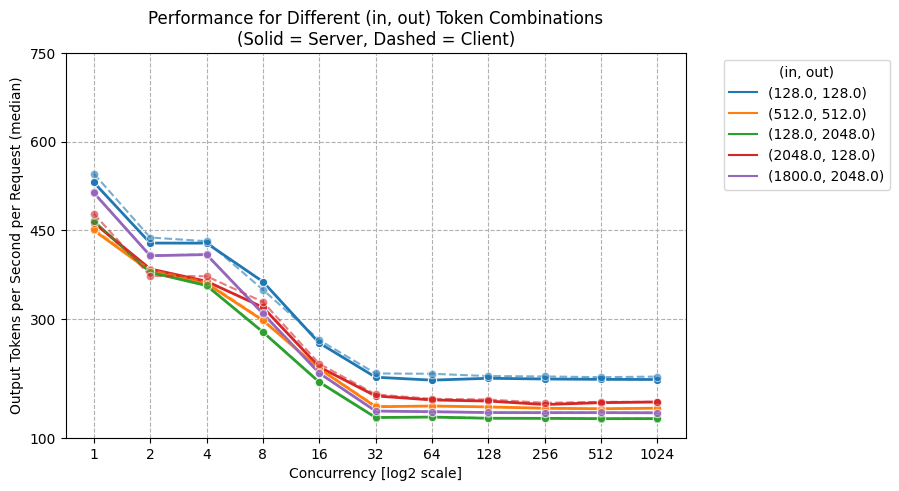

/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


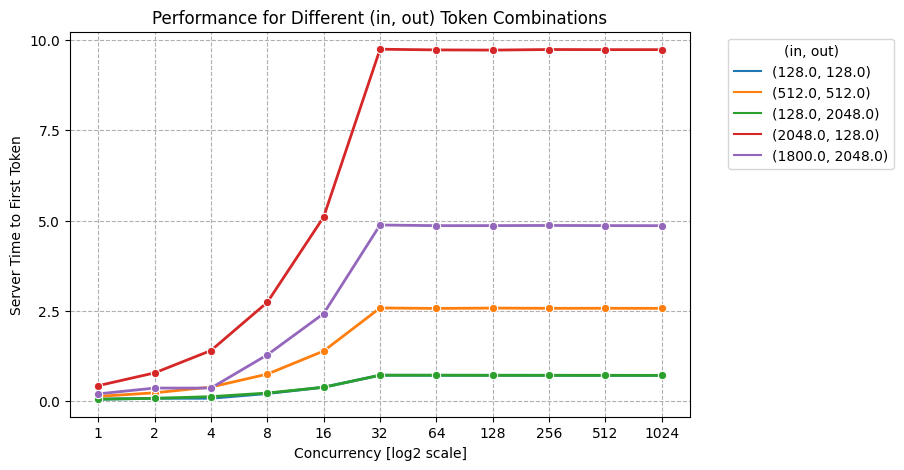

/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


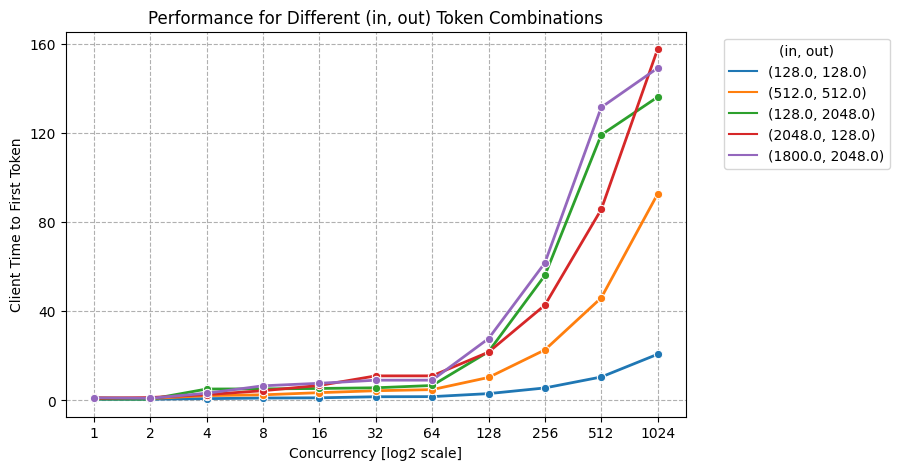

/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


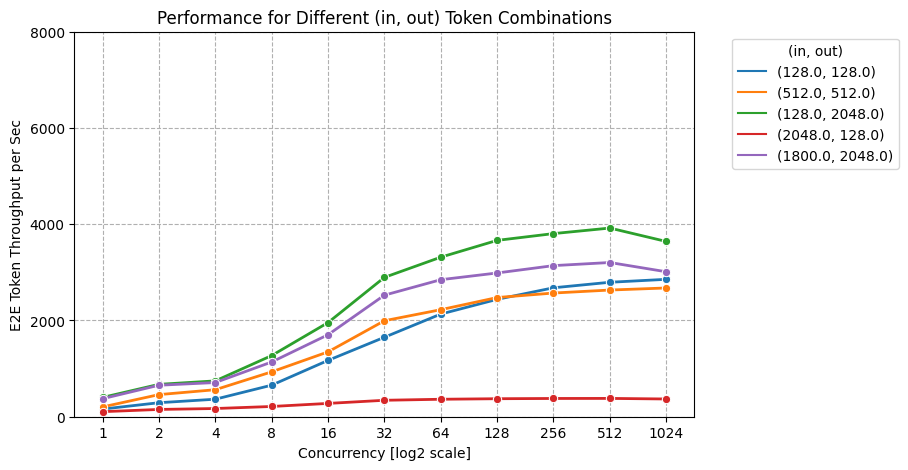

/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


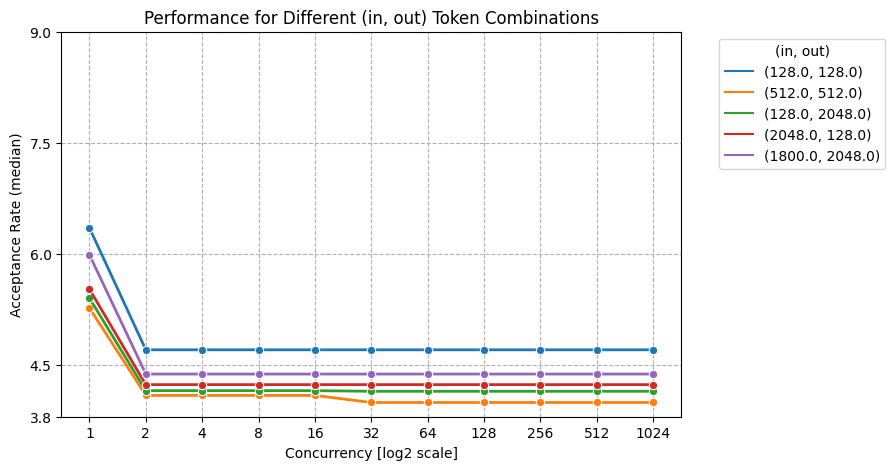

In [68]:
plot_benchmarking_data(df, 'output_token_per_s_median', 'Output Tokens per Second per Request (median)', yticks=[100,300,450,600,750])
plot_benchmarking_data(df, 'server_ttft_median', 'Server Time to First Token')
plot_benchmarking_data(df, 'client_ttft_median', 'Client Time to First Token')
plot_benchmarking_data(df, 'client_e2e_mean_token_per_s', 'E2E Token Throughput per Sec', yticks=[0,2000,4000, 6000, 8000])
plot_benchmarking_data(df, 'acceptance_rate_quantiles_median', 'Acceptance Rate (median)', yticks=[3.8,4.5,6.0,7.5, 9])


In [85]:
def plot_benchmarking_throughput_data(df, yticks, max_batch_size=32):
    df = df.reset_index()
    df['in_out'] = df.apply(lambda row: f"({row['in']}, {row['out']})", axis=1)
    df['throughput_token_per_s'] = df['output_token_per_s_median']*df['con'].apply(lambda x: min(x, max_batch_size))
    df['client_throughput_token_per_s'] = df['client_output_token_per_s_median']*df['con'].apply(lambda x: min(x, max_batch_size))

    plt.figure(figsize=(8, 5))

    # Plot main performance metric
    ax = sns.lineplot(data=df, x='con', y='throughput_token_per_s', hue='in_out', marker='o', linewidth=2)

    # Capture legend handles and labels from the first plot
    handles, labels = ax.get_legend_handles_labels()
    
    # Plot client_output_token_per_sec as a dashed line
    sns.lineplot(data=df, x='con', y='client_throughput_token_per_s', hue='in_out', 
                    marker='o', linestyle='dashed', alpha=0.6, legend=False)  # Disable legend here

    # Set x-axis to log2 scale
    plt.xscale("log", base=2)
    
    # Customize x-axis ticks
    xticks = sorted(df['con'].unique())
    plt.xticks(xticks, labels=[str(x) for x in xticks])
    
    # Standardize y-axis ticks
    if yticks is not None:
        plt.yticks(yticks)
        plt.ylim(min(yticks), max(yticks))
    else:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Ensure similar y-axis granularity
    
    
    # Labels and title
    plt.xlabel("Concurrency [log2 scale]")
    plt.ylabel("Throughput (token/s)")
    plt.title("Throughput for Different (in, out) Token Combinations\n(Solid = Server, Dashed = Client)")
    
    # Add legend only once
    plt.legend(handles, labels, title="(in, out)", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.grid(True, which="both", linestyle="--")
    plt.show()

/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rodrigom/.pyenv/versions/3.11.3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

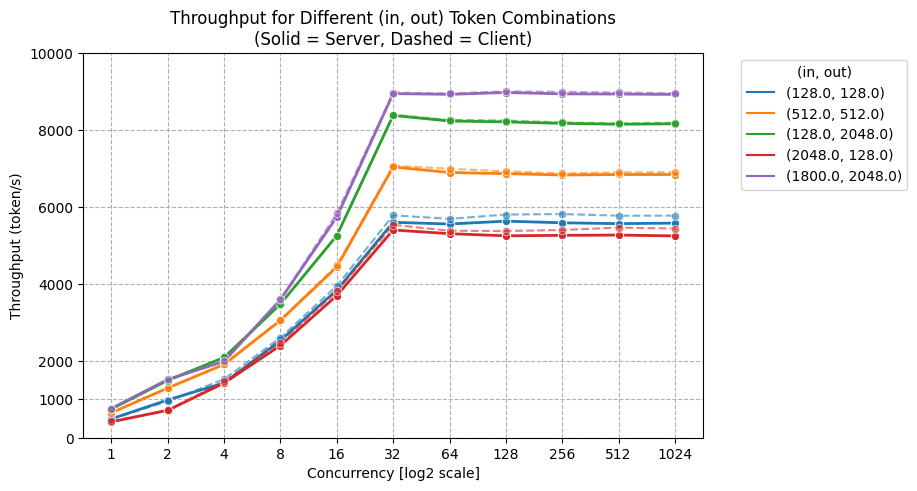

In [86]:
plot_benchmarking_throughput_data(df, yticks = [0,1000, 2000, 4000, 6000, 8000, 10000], max_batch_size=32)


In [ ]:
def read_json_files(directory: str) -> List[dict]:
    data = []
    
    if not os.path.isdir(directory):
        raise ValueError(f"The path '{directory}' is not a valid directory.")
    
    for filename in os.listdir(directory):
        if filename.endswith(".json") and "individual" in filename:
            input = filename.split('_')[3]
            output = filename.split('_')[4]
            con = filename.split('_')[5]
            file_path = os.path.join(directory, filename)
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    json_data = json.load(f)
                    if isinstance(json_data, list):  # Ensure the format is correct
                        
                        for json_datapoint in json_data:
                            if len(json_datapoint['error_msg'])==0:
                                data.append({
                                    "input": input,
                                    "output": output,
                                    "concurrency": con,
                                    "server_output_token_after_first_per_s_first_ten_per_request": json_datapoint['server_output_token_after_first_per_s_first_ten_per_request']
                                })
                    else:
                        print(f"Skipping {filename}: JSON is not in the expected format (list of dicts).")
            except (json.JSONDecodeError, IOError) as e:
                print(f"Error reading {filename}: {e}")
    
    return data

# Example usage
directory_path = '../data/results/softbank-high-accpt-aws'  # Replace with your actual directory path
data = read_json_files(directory_path)
print(data)

455.50984544934175
455.50984544934175
455.50984544934175
455.50984544934175
337.65987938834934
337.65987938834934
337.65987938834934
337.65987938834934
337.65987938834934
337.65987938834934
337.65987938834934
337.65987938834934
337.65987938834934
337.65987938834934
337.65987938834934
337.65987938834934
504.76513509006
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
211.45847895643612
212.986551309543
212.986551309543
212.986551309543
212.986551309543
212.986551309543
212.986551309543
212.986551309543
212.986551309543
212.986551309543
212.986551309543
212.986551309543

KeyError: 'server_output_token_after_first_per_s_first_ten_per_request'

In [105]:
json_datapoint

NameError: name 'json_datapoint' is not defined

In [91]:
pd.DataFrame.from_dict(data)

error_code error_msg       start_time         end_time  \
0           None            15:11:27.177647  15:11:29.255889   
1           None            15:11:27.164606  15:11:29.251814   
2           None            15:11:27.166009  15:11:29.255389   
3           None            15:11:27.176661  15:11:29.257949   
4           None            15:11:27.180876  15:11:32.394461   
...          ...       ...              ...              ...   
10230       None            16:26:39.184998  16:26:56.218973   
10231       None            16:26:39.193525  16:26:56.221784   
10232       None            16:26:39.188628  16:26:56.280575   
10233       None            16:26:39.171439  16:26:56.187844   
10234       None            15:24:05.831965  15:24:06.652027   

       server_number_input_tokens  server_number_output_tokens  \
0                           546.0                        512.0   
1                           546.0                        512.0   
2                           546.0                        512.0   
3                           546.0                        512.0   
4                           546.0                        512.0   
...                           ...                          ...   
10230                      1834.0                       2048.0   
10231                      1834.0                       2048.0   
10232                      1834.0                       2048.0   
10233                      1834.0                       2048.0   
10234                       162.0                        128.0   

       server_number_total_tokens  server_ttft_s  server_switching_time  \
0                          1058.0       0.400183                    NaN   
1                          1058.0       0.400183                    NaN   
2                          1058.0       0.400183                    NaN   
3                          1058.0       0.400183                    NaN   
4                          1058.0       1.400448                    NaN   
...                           ...            ...                    ...   
10230                      3882.0       4.869505                    NaN   
10231                      3882.0       4.869505                    NaN   
10232                      3882.0       4.869505                    NaN   
10233                      3882.0       4.869505                    NaN   
10234                       290.0       0.059955                    NaN   

       server_end_to_end_latency_s  ...  \
0                         1.524198  ...   
1                         1.524198  ...   
2                         1.524198  ...   
3                         1.524198  ...   
4                         2.916767  ...   
...                            ...  ...   
10230                    11.850313  ...   
10231                    11.850313  ...   
10232                    11.850313  ...   
10233                    11.850313  ...   
10234                     0.318644  ...   

       server_output_token_after_first_per_s_first_ten_per_request  \
0                                             455.509845             
1                                             455.509845             
2                                             455.509845             
3                                             455.509845             
4                                             337.659879             
...                                                  ...             
10230                                         293.375772             
10231                                         293.375772             
10232                                         293.375772             
10233                                         293.375772             
10234                                         489.647394             

       batch_size_used  acceptance_rate  number_input_tokens  \
0                  NaN         5.059406                546.0   
1                  NaN         5.059406                54